# Activity 2.1. Linear Regression
Last modified (20 Mar 2023)

### Learning Outcomes

In this activity we learn to:

- evaluate machine learning algorithm with synthetic data
- find optimal parameters for linear models directly by solving the normal equations
- describe and implement gradient descent and stochastic gradient
- describe the effect of the (stochastic) gradient parameters learning rate and batch size

### Prerequisites

- Activity 1
- Lecture 3

## Introduction

In this activity we will implement and evaluate different algorithms to fit the parameter vector $\mathbf{w} \in \mathbb{R}^p$ of a linear regression model with predictions
\begin{equation*}
y(\mathbf{x}, \mathbf{w}) = \boldsymbol{\phi}(\mathbf{x})\cdot \mathbf{w}
\end{equation*}
given training data $(\mathbf{x}_1, t_1), \dots, (\mathbf{x}_N, t_N) \in \mathbb{R}^M \times \mathbb{R}$ and some choice of **basis function** expansion $\boldsymbol{\phi}(\mathbf{x})=(\phi_1(\mathbf{x}), \dots, \phi_p(\mathbf{x}))$. To keep things simple, we will only consider linear basis functions here (while keeping the notation general).

All our algorithms will approach the model fitting problem by minimising the **mean (or sum) of squared errors**
\begin{align*}
E(\mathbf{w}) &= \frac{1}{2n} \sum_{n=1}^N (t_n - y(\mathbf{x_n}, \mathbf{w}))^2 \\
&= \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2
\end{align*}
where in the last form we have made use of the compact matrix/vector notation introduced in the lecture with target vector $\mathbf{t}=(t_1, \dots, t_N)$ and feature matrix $\boldsymbol{\Phi}$ that contains the feature expansions $\boldsymbol{\phi}(\mathbf{x_n})$ as rows.

### Outline

We will first define a test problem based on synthetic data and then implement and evaluate the following three fitting strategies:

1. First, we will implement the direct solution to optimising $E(\mathbf{w})$ by deriving the gradient of the objective function and, by setting it to the zero vector, obtain a sytem of linear equations (called the **normal equations**) that describe the optimal weights.
2. Then we use the gradient in a different way to define an iterative solver called **gradient descent** (GD). While this intermediate step is not particularly useful for linear models it is a very important to machine learning in general, because, in contrast to the first approach, it easily generalises to more complicated models.
3. Finally, we modify GD to only use approximate random gradients. The resulting **stochastic gradient descient** (SGD) variant, is not only easily generalisable to other models but can also be highly efficient for large sets of training data. 

In Activity 2.2, we will then move from ordinary least squares regression to regularised variants.

## A Synthetic Test Case

In addition to using real-world test cases for evaluating machine learning algorithms, one also often defines a **synthetic data generator**, i.e., a procedure that can be used to sample arbitrary amounts of data with known properties. Some advantage of this approach are that

1. We can evaluate the performance of the algorithm for any desired size of training data.
2. We can estimate the expected performance of the fitted model on unseen data to arbitrary precision because we can sample as many test data points as we like.
3. Even better, in addition to approximating the expected error on unseen data, we can directly investigate how well the fitted model parameters describe the data generator.

To illustrate the third point, let us go ahead and define our generator. We will implement a process that yields data points $(\mathbf{x}, t)$ such that
\begin{equation*}
t = \mathbf{x} \cdot \mathbf{w}^* + \epsilon
\end{equation*}
where $\epsilon \sim N(0, \sigma^2)$ is normally distributed noise with standard deviation $\sigma$ and $\mathbf{x}$ is drawn from some multivariate normal distribution (we will not be concerned too much with the distribution of $\mathbf{x}$ here, but have to specify it for the sake of completeness). With this process we can then evaluate a linear model in terms of how well the fitted weights $\mathbf{w}$ resemble the true (and optimal) weights $\mathbf{w}^*$.

Below, we implement the data generator for some general choice of **optimal weight** vector $\mathbf{w}^*$. Afterwards we will use the specific choice of 
$$\mathbf{w}^*=(-5, -3, 4, 5, 10)$$ 
as concrete example throughout this notebook. In particular, we will use the convention that the last element of $\mathbf{x}$ is set to the constant $1$, which allows us to fit a constant intercept term without further special treatment.

To sample the random part of the input vector and the noise variable $\epsilon$, we will use `multivariate_normal` and `norm` from the `scipy.stats` module. This module implements a wide range of statistical distributions, for which one can use the method `rvs` to sample random observations.

#### Task A: Complete the Data Generator

Complete the line below by setting epsilon to be a vector with random components sampled from the prescribed normal distribution for the noise component. 

Hint: Use [`scipy.stats.norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) (method `rvs`) with an appropriate choice of size (number of observations), location (mean), and scale (standard deviation).

In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal

def make_linear_data(n_samples, weights, noise=1, feature_mean = None, feature_cov = None, random_state=None):
    RNG = np.random.default_rng(seed=random_state)
    p = len(weights)

    #generate feature matrix
    feature_mean = np.zeros(p-1) if feature_mean is None else feature_mean
    feature_cov = np.eye(p-1) if feature_cov is None else feature_cov
    x = multivariate_normal.rvs(feature_mean, feature_cov, size=n_samples, random_state=RNG)
    x = np.hstack((np.ones(shape=(n_samples, 1)), x))

    #generate target vector
    epsilon = norm.rvs(0, noise, size=n_samples, random_state=RNG)
    t = x.dot(weights) + epsilon
    return x, t

weights_true = np.array([-5, -3, 4, 5, 10])
make_linear_data(10, weights=weights_true, random_state=0)

(array([[ 1.        ,  0.12573022, -0.13210486,  0.64042265,  0.10490012],
        [ 1.        , -0.53566937,  0.36159505,  1.30400005,  0.94708096],
        [ 1.        , -0.70373524, -1.26542147, -0.62327446,  0.04132598],
        [ 1.        , -2.32503077, -0.21879166, -1.24591095, -0.73226735],
        [ 1.        , -0.54425898, -0.31630016,  0.41163054,  1.04251337],
        [ 1.        , -0.12853466,  1.36646347, -0.66519467,  0.35151007],
        [ 1.        ,  0.90347018,  0.0940123 , -0.74349925, -0.92172538],
        [ 1.        , -0.45772583,  0.22019512, -1.00961818, -0.20917557],
        [ 1.        , -0.15922501,  0.54084558,  0.21465912,  0.35537271],
        [ 1.        , -0.65382861, -0.12961363,  0.78397547,  1.49343115]]),
 array([ -2.91356122,  15.55812197,  -9.30771727, -11.67099121,
          8.11531833,   0.72666239, -18.81109068,  -7.92563038,
          4.06971494,  16.61232386]))

## Direct Solution via Normal Equations

All our algorithms are based on understanding the gradient of the mean squared error function
\begin{equation*}
E(\mathbf{w}) = \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2
\end{equation*}
that, as we saw in the lecture, is given as 
\begin{equation*}
\nabla E(\mathbf{w}) = \frac{1}{n} \Phi^T(\Phi \mathbf{w} - \mathbf{t}) \enspace .
\end{equation*}
By setting this expression to the zero-vector and re-arranging, we derived that the weights that minimise the mean squared error can be found by solving the **normal equations**:
\begin{equation*}
\Phi^T\Phi \mathbf{w} = \Phi^T \mathbf{t} \enspace .
\end{equation*}
By accessing solvers for systems of linear equations, we can thus implement a first fitting algorithm very easily. Specifically in `numpy` we have the package [`numpy.linalg`](https://numpy.org/devdocs/reference/routines.linalg.html) for that.

#### Task B: Implement Normal Equations

Complete the line in the implementation of the linear model below that use [`numpy.linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) to solve the normal equations.

**Hint**: To set up the system of linear equations of the form $Ax=b$ for a matrix $A$ and a vector $b$, you to compute its left-hand-side (lhs) $A$ and right-hand-side (rhs) $b$. To do that for the normal equations you need to be able to:

- form the transpose of a matrix (see [ndarray.T](https://numpy.org/devdocs/reference/generated/numpy.ndarray.T.html))
- perform matrix multiplication (of which matrix/vector multiplication is a special case) (see the functions [`dot`](https://numpy.org/devdocs/reference/generated/numpy.dot.html) and [`matmul`](https://numpy.org/devdocs/reference/generated/numpy.matmul.html#numpy.matmul))

Note that `matmul` is also available via the operator `@` and `dot` is also available as a method of `ndarray` objects.

In [435]:
class DirectLinearRegressor:

    def __init__(self):
        pass

    def fit(self, x, y):
        # set up normal equations
        # here x is the feature matrix Phi and y is the target vector t
        rhs = x.T.dot(y)
        lhs = x.T.dot(x)
        
        # find optimal weights w (coefficients) by solving system
        self.coef_ = np.linalg.solve(lhs, rhs)
        return self

    def predict(self, x):
        return x.dot(self.coef_)


Let us test this approach by generating some training data and running the algorithm.

In [433]:
x_train, y_train = make_linear_data(100, weights=weights_true, random_state=1)

direct = DirectLinearRegressor().fit(x_train, y_train)
direct.coef_

array([-4.86757936, -3.02656842,  4.03331023,  4.95017083,  9.9227182 ])

As we can see, already with 100 training data points, our learned weight vector is very close to the true weight vector in the data generator.

In [447]:
np.linalg.norm(weights_true - direct.coef_)

0.16675161669551283

In [449]:
def mean_squared_error(y, y_hat):
    return ((y-y_hat)**2).mean()/2

x_test, y_test = make_linear_data(100000, weights=weights_true, random_state=2)

mean_squared_error(y_train, direct.predict(x_train)), mean_squared_error(y_test, direct.predict(x_test))

(0.4022834666007363, 0.5113008433504532)

### Task C: How good is the learned model?

**Explain in one paragraph how good you think is the expected error of the learned weight vector. How much do you think can it be improved (hint: what is the best possible weight vector)? Why? You can add one small computation in the next cell to test your analysis.**

*The expected test error achieved by the learned weight vector is very close to the optimal expected test error, which is achieved by the true weight vector used in the data generator (see next cell). The reason that the expected error cannot be improved beyond 0.5 is that this is half the variance of the noise component (which corresponds to the squared error of the true weight vector).*

In [450]:
mean_squared_error(y_test, x_test.dot(weights_true))

0.4976902337333803

## Gradient Descent

Fitting model parameters via solving a system of linear equations is a great approach whenever this is possible. However, outside of linear regression models (with the squared error function), the optimal solution is usually not described by a linear system. This motivates studying a more general algorithm that is also based on the gradient of the error function. Just instead of setting the gradient to zero and solving for $\mathbf{w}$, we now use the following iterative approach: 

- We start with an initial guess of the best weights, say $\mathbf{w}_0=\boldsymbol{0}$, and then 
- iteratively update our current guess by moving some distance along the negative gradient of the error function evaluated at that current guess. Formally, we set for $\tau=1, 2, \dots$
\begin{equation*}
\mathbf{w}_{\tau} = \mathbf{w}_{\tau-1} - \eta \nabla E(\mathbf{w}_{\tau-1})
\end{equation*}
- until the weights do not change any more substantially captured by the convergence criterion $\|\mathbf{w}_\tau - \mathbf{w}_{\tau-1}\| \leq \epsilon$ for some small positive **convergence threshold** $\epsilon$.

In the above update rule, $\eta$ is a small positive parameter called the **learning rate**. As a final parameter to the method we introduce $\tau_\mathrm{max}$ is large positive integer that gives an upper bound on how many iterations we will perform (we hope that the convergence criterion is already satisfied much earlier). 

The above strategy is motivated by the fact the negative gradient defines the update direction of steepest descent of the error function. Indeed, we know that, if the learning rate is not too large, the updated weights will have a smaller value than the current weights. What can we say about the limit of the weight sequence generated by our algorithm?

#### Task D: Explain Convergence of Gradient Descent

**Give an argument why the weight sequence generated by gradient descent must converge to the same optimal solution found by the direct method (for small enough $\eta$). Hint: remember the characterisation of the optimal solution by the gradient used for the direct method.**

*If $\boldsymbol{w}_{\tau - 1}$ is the optimal weight vector then $\boldsymbol{w}_{\tau}= \boldsymbol{w}_{\tau - 1}$ because the gradient is zero for the optimal weights. That means that the optimum is a fixpoint of the gradient update rule (and it is the only fixpoint because the error function is convex). In contrast for all other points, if the learning rate is small enough, there will be a reduction in error, hence the sequence must come arbitrary close to the optimal weights eventually.*

#### Task E: Implement Gradient Descent

**Complete the implementation below by adding one or two lines that compute the gradient of the error function at the current weight vector and then compute the update rule for the new weights. Note that in this implementation we store all the whole weight sequence in a large matrix to be able to visualise the workings of the algorithm afterwards.**

In [437]:
class GDLinearRegressor:

    def __init__(self, eta=0.01, tau_max=1000, epsilon=0.00001):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        
    def fit(self, x, y):
        # initial weight matrix with p columns and as many rows as we can have iterations
        # we will store each intermediate weight vector in one row of this matrix
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))

        for tau in range(1, self.tau_max+1):
            grad = x.T.dot(x.dot(self.w_[tau-1])-y)/n
            self.w_[tau] = self.w_[tau-1] - self.eta*grad
            # stopping criterion
            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon:
                break

        # set final coefficients
        self.coef_ = self.w_[tau] 
        # delete unused rows from weight matrix
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)


Now let us test the implementation on the previously generated training data and investigate the produced weights.

In [440]:
gd = GDLinearRegressor(eta=0.5, tau_max=10000).fit(x_train, y_train)
gd.coef_

array([-4.8675889 , -3.02657472,  4.03330642,  4.95015646,  9.92270385])

Indeed, those look extremely close to the optimal weights obtained by the closed form solution (which in turn were very close to the true weights). Let us compute just how close they are and the plot the weight sequence against the values of the direct solution plus the development of the train and test error across all iterations.

In [452]:
np.linalg.norm(gd.coef_-direct.coef_)

2.36166941657234e-05

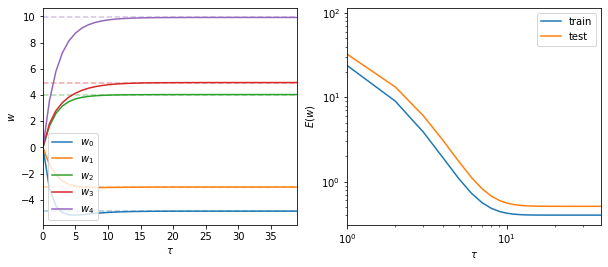

In [453]:
from matplotlib import pyplot as plt

def plot_weight_sequences(w, w_opt, ax):
    p = len(w_opt)
    for j in range(p):
        lines = ax.plot(w[:, j], label=f'$w_{j}$', zorder=2)
        ax.axhline(w_opt[j], linestyle='--', alpha=0.4, color=lines[0].get_color())
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('$w$')

def plot_errors(w, x_train, y_train, x_test, y_test, ax):
    train_risk = ((x_train.dot(w.T).T - y_train.T)**2).mean(axis=1)/2
    test_risk = ((x_test.dot(w.T).T - y_test.T)**2).mean(axis=1)/2
    ax.plot(train_risk, label='train')
    ax.plot(test_risk, label='test')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('$E(w)$')
    ax.margins(x=0)

_, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_weight_sequences(gd.w_, direct.coef_, axs[0])
plot_errors(gd.w_, x_train, y_train, x_test, y_test, axs[1])
plt.show()

## Stochastic Gradient Descent

While the repeated computation of the gradient vector in gradient descent might be as or even more expensive than the direct solution by solving the normal equations, it opens up an interesting venue for reducing the computational complexity. What if, instead of computing the exact gradient, we could obtain a reasonable approximation of the gradient by only looking at a few (random) data points?

Specifically, let us define the approximated or **stochastic gradient** as
\begin{align*}
\tilde{\nabla} E(\mathbf{w}) &= \nabla \frac{1}{2b} \sum_{n=n_1}^{n_b} (t_{n} - \boldsymbol{\phi}(\mathbf{x}_n)\cdot \mathbf{w})^2\\
&= \frac{1}{b}\tilde{\boldsymbol{\Phi}}^T(\tilde{\boldsymbol{\Phi}}\mathbf{w} - \tilde{\mathbf{t}})
\end{align*}
where $n_1, \dots, n_b$ are the indices of a bootstrap sample of the original dataset and $\tilde{\boldsymbol{\Phi}}$ and $\tilde{\mathbf{t}}$ are the feature matrix and target vector resulting from that sample of indices. 
In thic context, the parameter $b$ is also called the **batch size**.
With this definition, we can show relatively easily that the mean stochastic gradient is equal to the exact gradient, i.e., the expected value over all possible bootstrap samples satisfies:
\begin{equation*}
\mathbb{E}(\tilde{\nabla} E(\mathbf{w})) = \nabla E(\mathbf{w}) \enspace .
\end{equation*}

Analysing the convergence (and working out a good termination condition) are now a bit more involved, but for the purpose of this activity, and really this unit, we can just keep working with the same framework as before.

#### Task E: Implement stochastic gradient descient

**Finish the below implementation of stochastic gradient descent by adding code for drawing a bootstrap sample of prescribed batch size and computing the corresponding stochastic gradient. Hint: we have done something similar in the previous activity.**

In [467]:
class SGDLinearRegressor:

    def __init__(self, batch_size=1, eta=0.01, tau_max=1000, epsilon=0.00001, random_state=None):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            grad = x[idx].T.dot(x[idx].dot(self.w_[tau-1])-y[idx])/self.batch_size
            self.w_[tau] = self.w_[tau-1] - self.eta*grad
            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon:
                break
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)


Let us test this implementation with the extreme batch size of just 1.

In [472]:
sgd = SGDLinearRegressor(batch_size=1).fit(x_train, y_train)
sgd.coef_

array([-4.89353352, -2.99472443,  4.03786348,  4.93337621,  9.99213004])

Again the computed weights are very close to the exactly computed weights, but let us investigate how we got there.

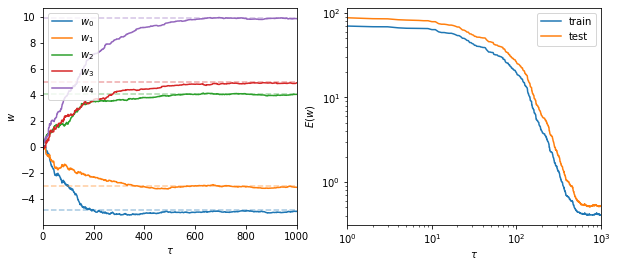

In [469]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_weight_sequences(sgd.w_, direct.coef_, axs[0])
plot_errors(sgd.w_, x_train, y_train, x_test, y_test, axs[1])
plt.show()

#### Task F: Effect of Batch Size

**Explain in two sentences how you expect the above picture to change for other (larger) batch sizes? Then test your hypothesis by completing the code below for running the experiment for a list of batch sizes.**

*With increasing batch size, the parameter traces should become as smooth as with the original gradient descent algorithm.*

In [470]:
batch_sizes = [1, 5, 10, len(x_train)]
sgds = []

for b in batch_sizes:
    sgds.append(SGDLinearRegressor(batch_size=b).fit(x_train, y_train))

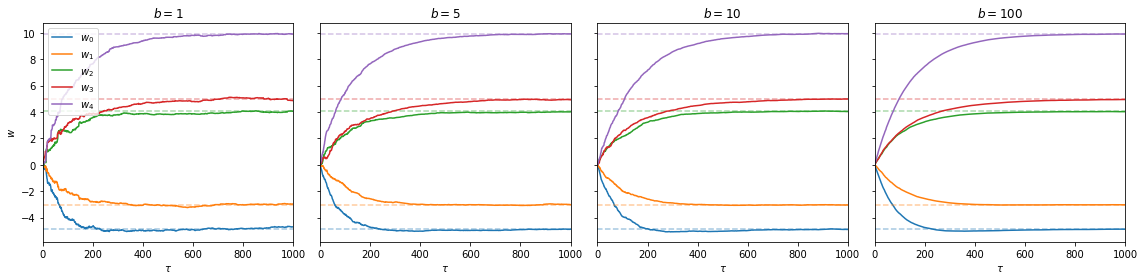

In [471]:
_, axs = plt.subplots(1, len(batch_sizes), figsize=(len(batch_sizes)*4, 4), tight_layout=True, sharey=True)
for i, b in enumerate(batch_sizes):
    plot_weight_sequences(sgds[i].w_, direct.coef_, axs[i])
    axs[i].set_title(f'$b={b}$')
    if i>0:
        axs[i].get_legend().remove()
        axs[i].set_ylabel(None)

## Conclusion

#### Task G: Summarise what you have learned

**Summarise again the ideas behind the three algorithms that we have implemented.**

*By computing the gradient of the error function and setting it to zero we obtain a system of linear equations (the normal equations) that we can simply solve via a linear algebra algorithm to obtain the optimal weight vector for the linear model. As an alternative we investigated an iterative algorithm, gradient descent, where instead of directly jumping to the optimal solution, we approach it step-by-step by updating our current guess into the direction of the negative error gradient. Finally, we could make this approach more efficient by considering an approximated stochastic gradient in every iteration that is computed only based on a few sampled datapoints (can be as little as one).*

We close with some further question that you might want to investigate independently:

- With our first training sample of size 100 we already got very close to the optimal weights. Was this just luck or is there a high probability of this too happen? How many datapoints do we need on average to approximately reconstruct the true weight vector?
- How does the learning rate affect the convergence rate of (stochastic) gradient descent? Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? You could validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $a/(b+\tau)$ for different values of $a$ and $b$)
- Could it happen with our current termination criterion that we stop stochastic gradient descent way too early with small badge sizes? Why and what could be a better criterion (and potentially weight update) that avoids this problem?